Show Ian's dataset, and figure out what it is 

Talk to Mario

Put on the family Centre 

The SLR data needs to be without any vlm... and it is included right now

Currently no requirement for it to be contingent

Test file for Wellington Dynamic DEM

# File Setup

In [ ]:
asdf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import datetime
import pyproj
import rioxarray
from scipy.interpolate import griddata
import scipy as sp
import folium
import os
import folium
from ipywidgets import interact, Dropdown
from IPython.display import display, clear_output

In [2]:
df_shoreline = pd.read_csv('linzcoast 1.dat',header=None,delimiter=' ')

In [3]:
df_shoreline.columns = ['lon','lat']

In [4]:
df_shoreline.dropna(axis=0,inplace=True)

In [5]:
# Define the current and target CRS using EPSG codes
current_crs = pyproj.CRS("EPSG:2193")  
target_crs = pyproj.CRS("EPSG:4326")

transformer = pyproj.Transformer.from_crs(current_crs, target_crs, always_xy=True,allow_ballpark=False)

# target_crs = pyproj.CRS("EPSG:4167")
# transformer_2 = pyproj.Transformer.from_crs(current_crs, target_crs, always_xy=True)

In [6]:
df_storm_surge = pd.read_csv('storm_surge.csv')

In [7]:
df_storm_surge['month'] = [x.split(' ')[0].split('/')[1] for x in df_storm_surge.datetime]
df_storm_surge['year'] = [x.split(' ')[0].split('/')[-1] for x in df_storm_surge.datetime]

In [8]:
df_storm_surge

,lat,lng,datetime,height,month,year
0,-41.25,174.5,1/01/2010 12:00,-0.034448,01,2010
1,-41.25,174.5,2/01/2010 12:00,0.062858,01,2010
2,-41.25,174.5,3/01/2010 12:00,0.096683,01,2010
3,-41.25,174.5,4/01/2010 12:00,0.014322,01,2010
4,-41.25,174.5,5/01/2010 12:00,-0.034867,01,2010
...,...,...,...,...,...,...
131483,-41.50,175.0,27/12/2099 12:00,-0.013351,12,2099
131484,-41.50,175.0,28/12/2099 12:00,-0.026677,12,2099
131485,-41.50,175.0,29/12/2099 12:00,-0.008993,12,2099
131486,-41.50,175.0,30/12/2099 12:00,0.014627,12,2099


In [9]:
df_annual_storm_surge = df_storm_surge[['year','height']].groupby('year').mean()

In [10]:
df_annual_storm_surge = df_annual_storm_surge.astype(float)
df_annual_storm_surge.index = df_annual_storm_surge.index.astype(float)

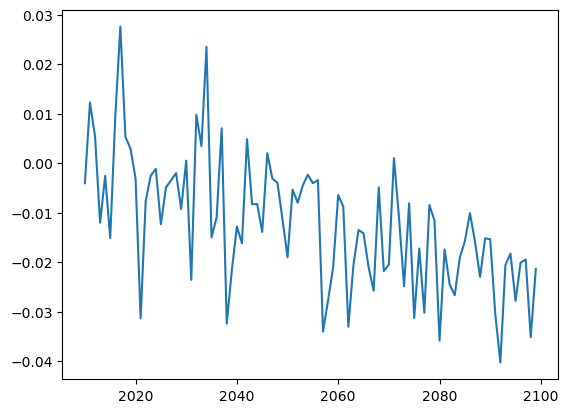

In [11]:
plt.plot(df_annual_storm_surge)

# Load data

In [12]:
# # df_vlms = pd.read_csv('our-changing-coast-insar_rates_searise.csv')
# xr_dem = rioxarray.open_rasterio('dem_8m_2012/MK.tif')

In [13]:
# df_vlms = pd.read_csv('our-changing-coast-insar_rates_searise.csv')
xr_dem = rioxarray.open_rasterio('dem_8m_2012_wgs//92L94-92L34.tif')

In [14]:
dem_values = xr_dem.values
fill_value = np.min(dem_values)

dem_values[dem_values==fill_value] = np.nan
xr_dem.values = dem_values

In [15]:
# Create a regular grid of coordinates
res = 500 # low res to make the initial calcs fast
x_regular = np.linspace(xr_dem['x'].min(), xr_dem['x'].max(), res)
y_regular = np.linspace(xr_dem['y'].min(), xr_dem['y'].max(), res)

# Interpolate data onto regular grid
data_interpolated = xr_dem[0,:,:].interp(y=y_regular, x=x_regular)

# Now you can use the interpolated data for transformation
new_DEM = xr.DataArray(data_interpolated,coords={"y":y_regular,"x":x_regular},dims=["y","x"])

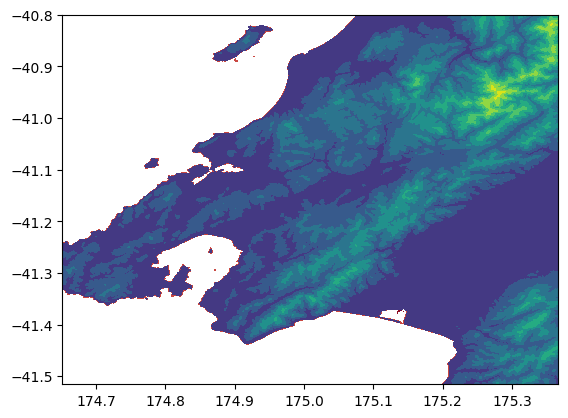

In [16]:
plt.contourf(xr_dem.x,xr_dem.y,xr_dem[0,:,:],cmap='RdBu')
plt.contourf(new_DEM.x,new_DEM.y,new_DEM)


In [17]:
# xx,yy = transformer.transform(new_DEM.x,new_DEM.y)

# new_DEM['x'] = xx
# new_DEM['y'] = yy

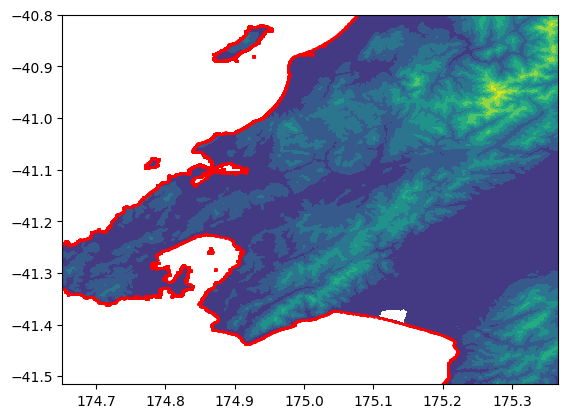

In [18]:
ax = plt.subplot2grid((1,1),(0,0))

ax.contourf(new_DEM.x,new_DEM.y,new_DEM)

ax.scatter(df_shoreline.lon,df_shoreline.lat,c='r',s=1)

ax.set_xlim([new_DEM.x.min(),new_DEM.x.max()])
ax.set_ylim([new_DEM.y.min(),new_DEM.y.max()])

plt.show()

In [19]:
inverted_data = new_DEM.isel(y=slice(None,None, -1))                           

C:\Users\shannonb\AppData\Local\Temp\ipykernel_18552\628147232.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('brg')



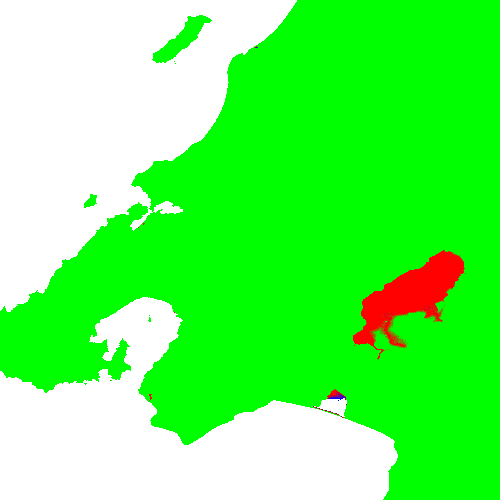

In [20]:
# LINZ images https://tiles-cdn.koordinates.com/services;key=22d3e91536f84549b87d292318a71519/tiles/v4/layer=105727/EPSG:3857/{z}/{x}/{y}.png
token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
tileurl = 'https://tiles-cdn.koordinates.com/services;key=22d3e91536f84549b87d292318a71519/tiles/v4/layer=105727/EPSG:3857/{z}/{x}/{y}.png'#'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)
wellington_coords = [-41.28664, 174.77557]
zoom = 11
cmap = plt.cm.get_cmap('brg')

m = folium.Map(location=wellington_coords, zoom_start=zoom)
custom_tile_layer = folium.TileLayer(tiles=tileurl, name='Satellite',attr='Mapbox',overlay=False).add_to(m)

temp_dem = new_DEM
# print(year,ssp)

folium.raster_layers.ImageOverlay(cmap(inverted_data),
                                  [[inverted_data.y.values.min(), inverted_data.x.values.min()],
                                   [inverted_data.y.values.max(), inverted_data.x.values.max()]],opacity=.5).add_to(m)

m

# VLMs

In [21]:
df_vlms = pd.read_csv('Welly_VLM_2018-2023_100m.txt',delimiter='\t')
df_vlms = df_vlms.astype(float)

In [22]:
df_vlms = df_vlms.rename(columns={'  0.000000':'lon','  0.000000.1':'lat'})

In [23]:
df_vlms.set_index(['lat','lon'],inplace=True)
df_vlms.columns = df_vlms.columns.astype(float)
df_vlms = df_vlms.reset_index()

In [24]:
cols = [x for x in df_vlms.columns if x not in ['lon','lat']]

In [25]:
x = new_DEM.x#np.linspace(df_vlms['lon'].min(), df_vlms['lon'].max(), 100)
y = new_DEM.y#np.linspace(df_vlms['lat'].min(), df_vlms['lat'].max(), 100)

X, Y = np.meshgrid(x, y)

example_year = 2018
Z = griddata((df_vlms['lon'], df_vlms['lat']), df_vlms[2018.0], (X, Y), method='linear')
Z = np.nan_to_num(Z,nan=0)

Z_nax = Z[:,:,np.newaxis]
duplicated_arr = np.broadcast_to(Z_nax, (*Z.shape, len(cols)))
duplicated_arr = duplicated_arr.copy()
# new array has dims of lon,lat,time

i = 0
for year in cols:
    duplicated_arr[:,:,i] = griddata((df_vlms['lon'], df_vlms['lat']), df_vlms[year], (X, Y), method='linear')
    i+=1

xr_vlms = xr.DataArray(duplicated_arr,coords={"lon":np.array(x),"lat":np.array(y),"years":cols},dims=['lon','lat','years'])

xr_vlm_interp1 = xr_vlms.interpolate_na(dim='lat',method='linear')
xr_vlm_interp2 = xr_vlms.interpolate_na(dim='lon',method='linear')

xr_vlm_interp = (xr_vlm_interp1+xr_vlm_interp2)/2

In [26]:
xr_vlm_interp

<xarray.DataArray (lon: 500, lat: 500, years: 152)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lon      (lon) float64 174.7 174.7 174.7 174.7 ... 175.4 175.4 175.4 175.4
  * lat      (lat) float64 -41.52 -41.51 -41.51 -41.51 ... -40.8 -40.8 -40.8
  * years    (years) float64 2.018e+03 2.018e+03 ... 2.023e+03 2.023e+03

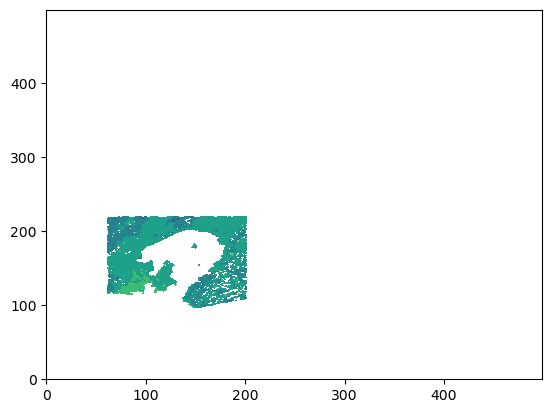

In [27]:
plt.contourf(duplicated_arr[:,:,50])

# Load SLR Data

In [28]:
xr_slr = sp.io.loadmat('../../Ian_relabelled_sites/total_volc_noVLMssp585_low_confidence_values.mat')

lats = {x:y for x,y in zip(xr_slr['locations'].squeeze(),xr_slr['lat'].squeeze())}
lons = {x:y for x,y in zip(xr_slr['locations'].squeeze(),xr_slr['lon'].squeeze())}

x = new_DEM.x
y = new_DEM.y

years = np.unique(xr_slr['years'])
quantiles = [0.17,0.5,0.83]

X, Y = np.meshgrid(x, y)

example_year = np.min(years)
example_quantile = np.min(quantiles)

In [29]:
file_names = os.listdir("../../Ian_relabelled_sites/")
file_names = [x for x in file_names if ('total' in x)&('low' in x)&('_noVLM' in x)]

In [30]:
duplicated_array = np.zeros((len(x),len(y),len(years),len(quantiles),len(file_names)))

In [31]:
k = 0
for file in file_names:
    xr_slr = sp.io.loadmat(f'../../Ian_relabelled_sites/{file}')
    
    xr_slr = xr.DataArray(xr_slr['sea_level_change'],
                          coords={'locations':xr_slr['locations'].squeeze(),'years':xr_slr['years'].squeeze(),'quantiles':xr_slr['quantiles'].squeeze()},
                         dims=['locations','years','quantiles'])
    
    df_slr = xr_slr.sel(quantiles=quantiles).to_dataframe('slr')
    
    df_slr['Lat'] = [lats[x] for x in df_slr.reset_index()['locations']]
    df_slr['Lon'] = [lons[x] for x in df_slr.reset_index()['locations']]
    
    # Focus on the wellington region
    df_slr = df_slr[(df_slr.Lon>np.min(new_DEM.x.values))&(df_slr.Lat>np.min(new_DEM.y.values))&(df_slr.Lon<np.max(new_DEM.x.values))&(df_slr.Lat<np.max(new_DEM.y.values))]
    
    df_slr = df_slr.reset_index().drop('locations',axis=1)
    
    i = 0
    for year in years:
        j = 0
        for quantile in quantiles:
            df_slr_inst = df_slr[(df_slr.years==year)&(df_slr.quantiles==quantile)]
            duplicated_array[:,:,i,j,k] = griddata((df_slr_inst['Lon'], df_slr_inst['Lat']), df_slr_inst['slr'], (X, Y), method='linear')
            j+=1
        i+=1
    k+=1

xr_slr = xr.DataArray(duplicated_array,coords={"Lon":np.array(x),"Lat":np.array(y),"years":years,"quantiles":quantiles,"scenarios":file_names},dims=['Lon','Lat','years','quantiles','scenarios'])

filled_x = xr_slr.ffill('Lon').bfill('Lat')
filled_y = xr_slr.ffill('Lat').bfill('Lon')
xr_slr_filled = (filled_x+filled_y)/2
    

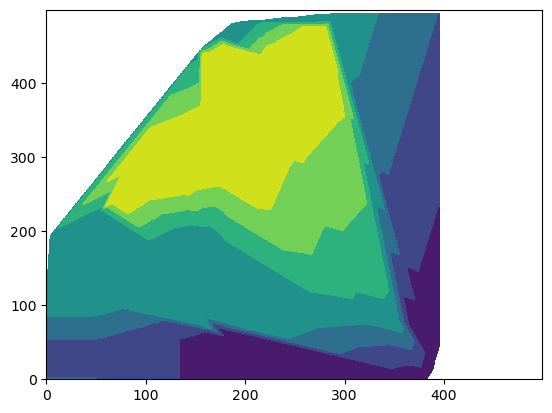

In [32]:
plt.contourf(xr_slr_filled[:,:,0,0,0])

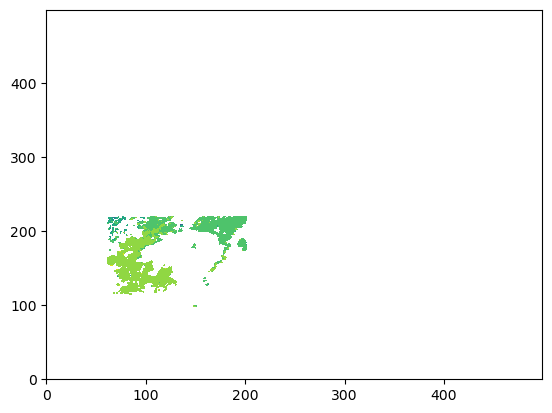

In [33]:
plt.contourf(xr_vlms[:,:,-1])

In [34]:
xr_vlm_interp

<xarray.DataArray (lon: 500, lat: 500, years: 152)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lon      (lon) float64 174.7 174.7 174.7 174.7 ... 175.4 175.4 175.4 175.4
  * lat      (lat) float64 -41.52 -41.51 -41.51 -41.51 ... -40.8 -40.8 -40.8
  * years    (years) float64 2.018e+03 2.018e+03 ... 2.023e+03 2.023e+03

# Adding SLR and VLM together Data

In [35]:
# Find a mean of the rates and project forward
xr_vlm_mean = xr_vlm_interp.mean(dim='years',skipna=True)
xr_vlm_mean = xr_vlm_mean.expand_dims({'years':xr_slr.years.values})

year_count = (xr_vlm_mean.years-np.min(xr_vlm_mean.years)) #should really start when the DEM was made for
xr_vlm_forecast = xr_vlm_mean*np.array(year_count)[:,None,None]
xr_vlm_forecast = xr_vlm_forecast.transpose('lon','lat','years')
xr_slr_vlm_adjusted = xr_slr_filled-np.array(xr_vlm_forecast)[:,:,:,None,None]

In [36]:
xr_slr_vlm_adjusted

<xarray.DataArray (Lon: 500, Lat: 500, years: 29, quantiles: 3, scenarios: 2)>
array([[[[[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
...
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         ...,

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]],

         [[nan, nan],
          [nan, nan],
          [nan, nan]]]]])
Coordinates:
  * Lon        (Lon) float64 174.7 174.7 174.7 174.7 ... 175.4 175.4 175.4 175.4
  * Lat        (Lat) float64 -41.52 -41.51 -41.51 -41.51 ... -40.8 -40.8 -40.8
  * years      (years) int32 2020 2030 2040 2050 2060 ... 2270 2280 2290 2300
  * quantiles  (quantiles) float64 0.17 0.5 0.83
  * scenarios  (scenarios) <U48 'total_volc_noVLMssp126_low_confidence_values...

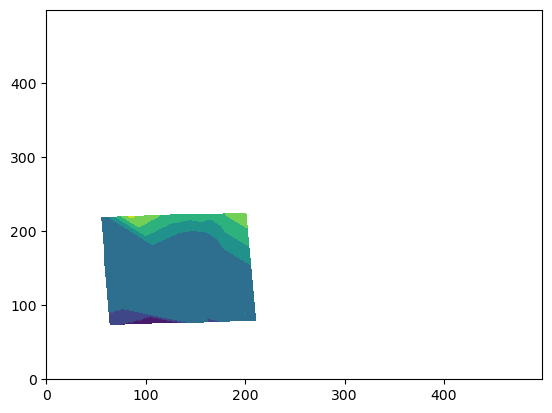

In [37]:
plt.contourf(xr_slr_vlm_adjusted[:,:,0,0,0])

# Flooding without VLM

In [38]:
new_DEM_mask = new_DEM.copy()
new_DEM_mask = new_DEM_mask/new_DEM_mask
new_DEM_mask = new_DEM_mask.fillna(123456789)#where(new_DEM_mask!=float('NaN'),123456789)
new_DEM_mask = new_DEM_mask.where(new_DEM_mask!=1,np.nan)
new_DEM_mask = new_DEM_mask.where(new_DEM_mask!=123456789,1)

In [39]:
masked_array_dict = {}
flooded_dict = {}

for year in years:
    for scenario in file_names:
        xr_slr_vlm_adjusted_year = xr_slr_vlm_adjusted.sel(years=year,scenarios=scenario)
        
        new_DEM_flooded_low = new_DEM-np.array(xr_slr_vlm_adjusted_year.sel(quantiles=np.min(quantiles)))/1000
        new_DEM_flooded_low = new_DEM_flooded_low
        flooded_low = new_DEM_flooded_low.where(new_DEM_flooded_low<0,np.nan)*0+1
        
        new_DEM_flooded_mid = new_DEM-np.array(xr_slr_vlm_adjusted_year.sel(quantiles=0.5))/1000
        new_DEM_flooded_mid = new_DEM_flooded_mid
        flooded_mid = new_DEM_flooded_mid.where(new_DEM_flooded_mid<0,np.nan)*0+1
        
        new_DEM_flooded_high = new_DEM-np.array(xr_slr_vlm_adjusted_year.sel(quantiles=np.max(quantiles)))/1000
        new_DEM_flooded_high = new_DEM_flooded_high
        flooded_high = new_DEM_flooded_high.where(new_DEM_flooded_high<0,np.nan)*0+1
        
        flooded = flooded_low.fillna(0)+flooded_mid.fillna(0)+flooded_high.fillna(0)
        flooded = flooded.where(flooded>0,np.nan)
        
        masked_flooded = np.ma.masked_invalid(flooded)
        masked_flooded = (np.max(masked_flooded)-masked_flooded)/(np.max(masked_flooded)-np.min(masked_flooded))
        masked_flooded = masked_flooded[::-1,:]

        masked_array_dict.update({
            (year,scenario):masked_flooded
        })

        flooded_dict.update({
            (year,scenario):flooded
        })


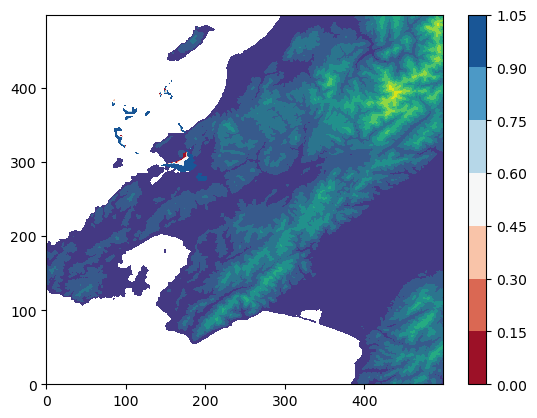

In [40]:
year = 2300
scenario = 'total_volc_noVLMssp585_low_confidence_values.mat'

flooded = masked_array_dict[(year,scenario)]

output = plt.contourf(new_DEM)
output = plt.contourf(flooded,cmap='RdBu')



plt.colorbar(output)

In [41]:
# # Coordinates for Wellington, New Zealand
# wellington_coords = [-41.28664, 174.77557]

# # Create a map centered around Wellington
# # map_wellington = folium.Map(location=wellington_coords, zoom_start=12)
# token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
# tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)
# map_wellington = folium.Map(location=wellington_coords, zoom_start=11)
# custom_tile_layer = folium.TileLayer(tiles=tileurl, name='Satellite',attr='Mapbox',overlay=False).add_to(map_wellington)


# blue_cmap = plt.cm.get_cmap('brg')

# year = 2300
# ssp = 'total_volc_noVLMssp585_low_confidence_values.mat'

# masked_flooded = masked_array_dict[(year,ssp)]
# flooded = flooded_dict[(year,ssp)]

# folium.raster_layers.ImageOverlay(blue_cmap(masked_flooded),
#                                   [[flooded.y.values.min(), flooded.x.values.min()],
#                                    [flooded.y.values.max(), flooded.x.values.max()]],opacity=1).add_to(map_wellington)



# # Display the map
# map_wellington

In [42]:
# import folium
# from ipywidgets import Dropdown, Output, VBox
# from IPython.display import display, clear_output

# # Sample datasets
# # dataset1 = [[34.052235, -118.243683], [40.712776, -74.005974]]
# # dataset2 = [[51.5074, -0.1278], [48.8566, 2.3522]]

# # Define a function to create a Folium map


# # Create initial map
# output = Output()
# display(output)
# with output:
#     m = create_map(2020,'total_volc_noVLMssp126_low_confidence_values.mat')
#     display(m)

# # Define dropdown options
# dropdown_options1 = ['SSP1', 'SSP5']
# dropdown_options2 = years

# # Define dropdown widget
# dropdown1 = Dropdown(options=dropdown_options1, description='Select SSP')
# dropdown2 = Dropdown(options=dropdown_options2, description='Select Year')
# dropdown_box = VBox([dropdown1,dropdown2])
# display(dropdown_box)

# # Define callback function to update map when dropdown value changes
# def dropdown_callback(change):
#     output.clear_output(wait=True)
#     with output:
#         # if (change['owner'].description == 'Select SSP')|(change['owner'].description == 'Select Year'):
#             print(dropdown1.value)
            
#             m = create_map(dropdown2.value,f"total_volc_noVLM{dropdown1.value}85_low_confidence_values.mat")
#         #     elif dropdown2.value == 'SSP1':
#         #         m = create_map('total_volc_noVLMssp126_low_confidence_values.mat')
#         # if change['owner'].description == 'Select Dataset 1':
            
#         #     m = create_map('total_volc_noVLMssp585_low_confidence_values.mat')
#             display(m)

# dropdown.observe(dropdown_callback, names='value')


In [43]:
cmap = plt.cm.get_cmap('brg')

wellington_coords = [-41.28664, 174.77557]
zoom = 11

def create_map(year,ssp):
    token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
    tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)
    m = folium.Map(location=wellington_coords, zoom_start=zoom)
    custom_tile_layer = folium.TileLayer(tiles=tileurl, name='Satellite',attr='Mapbox',overlay=False).add_to(m)

    masked_flooded = masked_array_dict[(year,ssp)]
    flooded = flooded_dict[(year,ssp)]

    # print(year,ssp)
    
    folium.raster_layers.ImageOverlay(cmap(masked_flooded),
                                      [[flooded.y.values.min(), flooded.x.values.min()],
                                       [flooded.y.values.max(), flooded.x.values.max()]],opacity=.5).add_to(m)

    return(m)
    
# Define dropdown options
dropdown_options1 = ['ssp126', 'ssp585']
dropdown_options2 = years

# Define callback function to update map when dropdown value changes
def update_map(year, ssp):
    clear_output(wait=True)
    try:
        m = create_map(year, f'total_volc_noVLM{ssp}_low_confidence_values.mat')
        display(m)
    except Exception as e:
        print(f"Error occurred: {e}")

# Create interactive dropdowns
interact(update_map, year=dropdown_options2, ssp=dropdown_options1)


C:\Users\shannonb\AppData\Local\Temp\ipykernel_18552\1785278694.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('brg')


interactive(children=(Dropdown(description='year', options=(2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 21…

<function __main__.update_map(year, ssp)>

In [44]:
asdf

NameError: name 'asdf' is not defined

In [ ]:
output = plt.contourf(xr_vlm_forecast[:,:,-1])

plt.colorbar(output)

In [ ]:
output = plt.contourf(xr_slr[:,:,-1,0,1])

plt.colorbar(output)

In [ ]:
output = plt.contourf(xr_slr_vlm_adjusted[:,:,-1,0,1])

plt.colorbar(output)

In [ ]:
output = plt.contourf(xr_vlm_forecast[-1,:,:])

plt.colorbar(output)

In [ ]:
array_data = np.random.rand(29)

In [ ]:
array_data

In [ ]:
xr_vlm_mean.shape

In [ ]:
np.max(years)

In [ ]:
years

In [ ]:
            # years = point_data['years'].values
            # values = point_data.values

            # df = pd.DataFrame.from_dict({'years':years,'values':values}).dropna()
            # if len(df)<1:
            #     continue
            # plt.plot(df.years,df.values)
            # print(df)
            # plt.show()
            # asdf
            
            
            # coef = np.polyfit(years, values, 1)  # Fit a linear regression model

            # # Extrapolate future values
            # future_years = years#range

In [ ]:
# # Function to perform linear extrapolation through time
# def linear_extrapolate(data):
#     # Calculate the linear regression coefficients along the years dimension
#     years = xr_vlms['years'].values
#     # values = data.values

#     # print(years.shape)
#     # print(values.shape)

#     df = pd.DataFrame.from_dict({"years":years,"vlm":data}).dropna()
    
#     coef = np.polyfit(df.years, df.vlm, 1)

#     # Extrapolate future values using the linear equation
#     future_years = xr_slr.years.values  # Extrapolate for the next 10 years
#     future_values = np.polyval(coef, future_years)  # Extrapolate using the linear equation

#     # Create a new xarray data array for the extrapolated values
#     extrapolated_data = xr.DataArray(future_values,
#                                      dims=('future_years',),
#                                      coords={'future_years': future_years})

#     return({x:y for x,y in zip(future_years,extrapolated_data.values)})

# # Apply linear extrapolation through time for each lat-lon point
# extrapolated_data = linear_extrapolate(xr_vlms[500,500])

# print(extrapolated_data)


In [ ]:
plt.plot(xr_vlms[500,500])



coef = np.polyfit(df.years, df.vlm, 1)

In [ ]:
coef

In [ ]:
df.dropna()

In [ ]:
data = xr.DataArray(np.random.rand(3, 3, 10), 
                    dims=('lat', 'lon', 'years'),
                    coords={'lat': [1, 2, 3], 'lon': [4, 5, 6], 'years': range(10)})

In [ ]:
linear_extrapolate(xr_vlms)

In [ ]:
xr_vlms

In [ ]:
m.location

In [ ]:
[[flooded.y.values.min(), flooded.x.values.min()],
                                   [flooded.y.values.max(), flooded.x.values.max()]]

In [ ]:
np.unique(new_DEM_flooded)

In [ ]:
plt.contourf(Z)

plt.contourf(new_DEM,cmap='RdBu')

In [ ]:
xr_vlm_interp

In [ ]:
plt.contourf(xr_vlm_interp)

In [ ]:
plt.contourf(Z)

In [ ]:
np.min(xr_dem.x)

In [ ]:
np.min(xr_dem.x.values)

In [ ]:
xr_dem.x

In [ ]:
xr_dem = xr.open_dataset('our-changing-coast-nz_200m_dem_15m_coastal_strip.nc')

In [ ]:
xr_dem

In [ ]:
new_DEM

In [ ]:
wellington_DEM = new_DEM[(new_DEM.y>-41.383339)&(new_DEM.y>-41.160978),(new_DEM.x>174.621671)&(new_DEM.x>174.949513)]

In [ ]:
wellington_DEM

In [ ]:
plt.imshow(wellington_DEM.transpose())

In [ ]:
(new_DEM.y>-41.383339)&(new_DEM.y>-41.160978)

In [ ]:
data_interpolated

In [ ]:
data_interpolated

In [ ]:
plt.imshow(xr_dem.band_data[0,:,:])

In [ ]:
np.array(xr_dem.y)

In [ ]:
xx,yy = np.meshgrid(np.array(xr_dem.x),np.array(xr_dem.y))
combined_array = np.column_stack((xx.ravel(),yy.ravel()))

In [ ]:
combined_array = transformer.transform(combined_array[:,0],combined_array[:,1])

In [ ]:
reshaped_array = np.array(combined_array).reshape((2,np.array(xr_dem.x).shape[0],np.array(xr_dem.y).shape[0]))

In [ ]:
# Create xarray Dataset
dataset = xr.Dataset(
    {
        "latitude": (["x", "y"], reshaped_array[1]),
        "longitude": (["x", "y"], reshaped_array[0]),
        "data": (["x", "y"], data),
    },
    coords={"x": np.arange(x), "y": np.arange(y)},



In [ ]:
reshaped_array[1]

In [ ]:
reshaped_array.shape

In [ ]:
reshaped_array[0][0,:]

In [ ]:
reshaped_array[0][1,:]

In [ ]:
reshaped_array[0][-1,:]

In [ ]:
np.array(combined_array).shape

In [ ]:
np.flip(combined_array).shape